In [5]:
%%capture
import os
import datetime
import random

import numpy as np
from numpy import array
from numpy import hstack
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta 
from sklearn.preprocessing import MinMaxScaler
from scipy.io import arff
from sklearn.metrics import precision_score, roc_auc_score
from scipy.special import expit
from scipy.signal import butter, lfilter, freqz
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime
from sklearn.model_selection import train_test_split


In [3]:
train_df = pd.read_csv("train_df.csv",low_memory=False)
test_df = pd.read_csv("test_df.csv",low_memory=False)
val_df = pd.read_csv("val_df.csv",low_memory=False)

all_columns = ["awake","breath_average", "deep", "duration", "hr_average", "hr_lowest",
          "light", "rem", "restless", "temperature_delta","total", "rmssd", "score"]

train_df = train_df[all_columns]
test_df = test_df[all_columns]
val_df = val_df[all_columns]

train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')
val_df = val_df.fillna(method='ffill')

In [4]:
from sklearn.preprocessing import MinMaxScaler
train_df_n = MinMaxScaler().fit_transform(train_df.values)
train_df = pd.DataFrame(train_df_n)
test_df_n = MinMaxScaler().fit_transform(test_df.values)
test_df = pd.DataFrame(test_df_n)
val_df_n = MinMaxScaler().fit_transform(val_df.values)
val_df = pd.DataFrame(val_df_n)

train_df.columns = all_columns
test_df.columns = all_columns
val_df.columns = all_columns


In [5]:
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
		# find the end of this pattern
    end_ix = i + n_steps
		# check if we are beyond the dataset
    if end_ix > len(sequences): break
		# gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [6]:
dataset = train_df.values
# choose a number of time steps
n_steps = 15
# convert into input/output
X, y = split_sequences(dataset, n_steps)

n_features = X.shape[2]

In [7]:
dataset_test = test_df.values
X_test, y_test = split_sequences(dataset_test, n_steps)

In [8]:
print(X_test.shape)
print(y_test.shape)

(9940, 15, 12)
(9940,)


In [9]:
dataset_val = val_df.values
X_val, y_val = split_sequences(dataset_val, n_steps)

In [10]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten


def createModel(n_steps, n_features):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(128, input_shape=(n_steps, n_features), return_sequences=True))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
    model.add(tf.keras.layers.LSTM(64, return_sequences=True))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
    model.add(tf.keras.layers.Dropout(0.3)) 
    model.add(tf.keras.layers.LSTM(28, return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.3)) 
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer='adam', loss='mse')

    return model

Using TensorFlow backend.


In [11]:
# create model
model = createModel(n_steps,n_features)
model.fit(X, y, epochs=1, batch_size=50, validation_data=(X_val, y_val), shuffle=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 30804 samples, validate on 10202 samples
30804/30804 [==============================] - 52s 2ms/sample - loss: 0.0373 - val_loss: 0.0312


In [12]:
from sklearn.metrics import mean_squared_error as mse
y_pred_test = model.predict(X_test)
mse(y_test, y_pred_test)

0.025766249551671616

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 128)           72192     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 15, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 28)                10416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28)                0

In [ ]:
#model.save('model.v1') 

In [14]:
!pip install shap
import shap

In [1]:
!pip install tensorflow==1.14
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [510]:
window_len = 10

Deep Explainer

In [511]:
X.shape

(30809, 10, 12)

In [512]:
explainer = shap.DeepExplainer(model, X[:1000])
shap_values = explainer.shap_values(X_test[: window_len], check_additivity=False)

In [513]:
explainer.expected_value

array([0.6649594], dtype=float32)

In [514]:
print(len(shap_values))

1


In [515]:
print(X_test[:window_len].shape)

(10, 10, 12)


In [516]:
print(shap_values[0].shape)

(10, 10, 12)


In [517]:
print(shap_values[0][0].shape)

(10, 12)


In [518]:
i = 0
j = 0
shap.initjs()
features = ["awake","breath_average", "deep", "duration", "hr_average", "hr_lowest",
          "light", "rem", "restless", "temperature_delta","total", 'rmssd']
x_test_df = pd.DataFrame(data=X_test[:window_len][i][j].reshape(1,n_features), columns = features)
shap.force_plot(explainer.expected_value[0], shap_values[0][i][j], x_test_df)

In [519]:
# avg SHAP for all observations
shap_average_value = np.abs(shap_values[0]).mean(axis=0)
shap.initjs()
x_average_value = pd.DataFrame(data=X_test[:window_len].mean(axis=0), columns = features)
shap.force_plot(0, shap_average_value, x_average_value)

In [520]:
shap_values_2D = shap_values[0].reshape(-1,n_features)
X_test_2D = X_test[:window_len].reshape(-1,n_features)


shap_values_2D.shape, X_test_2D.shape
x_test_2d = pd.DataFrame(data=X_test_2D, columns = features)
x_test_2d.corr()

awake  breath_average  ...     total     rmssd
awake              1.000000        0.151015  ...  0.024108 -0.347354
breath_average     0.151015        1.000000  ...  0.184575  0.288270
deep              -0.401466       -0.042901  ...  0.232916  0.398822
duration           0.502772        0.232374  ...  0.876288 -0.309780
hr_average         0.216897        0.026977  ...  0.174398 -0.874798
hr_lowest          0.133283       -0.115203  ...  0.120602 -0.755488
light              0.060902        0.255895  ...  0.849897 -0.281049
rem                0.384179        0.040403  ...  0.770580 -0.326310
restless           0.420036        0.024846  ... -0.231838 -0.347909
temperature_delta  0.134755        0.295190  ...  0.537685 -0.096174
total              0.024108        0.184575  ...  1.000000 -0.164665
rmssd             -0.347354        0.288270  ... -0.164665  1.000000

[12 rows x 12 columns]

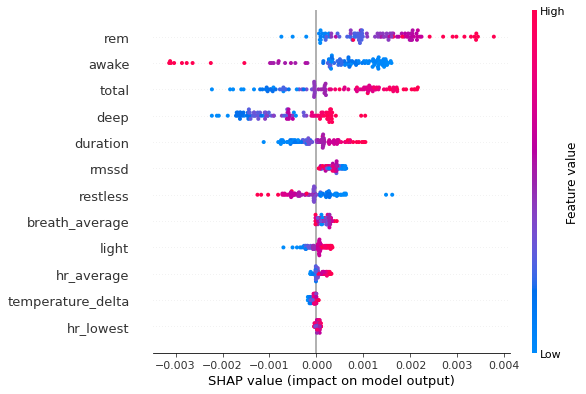

In [521]:
shap.summary_plot(shap_values_2D, x_test_2d)

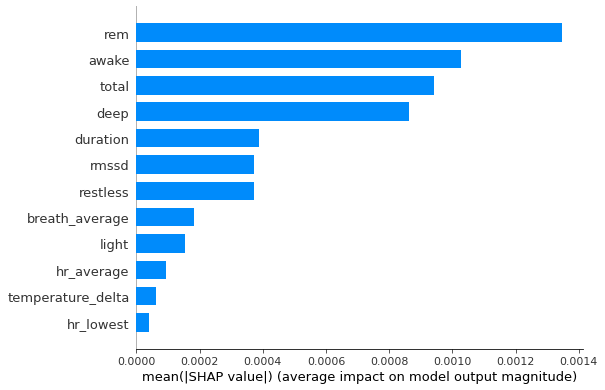

In [522]:
shap.summary_plot(shap_values_2D, x_test_2d, plot_type="bar")

_______ time step 0 ___________


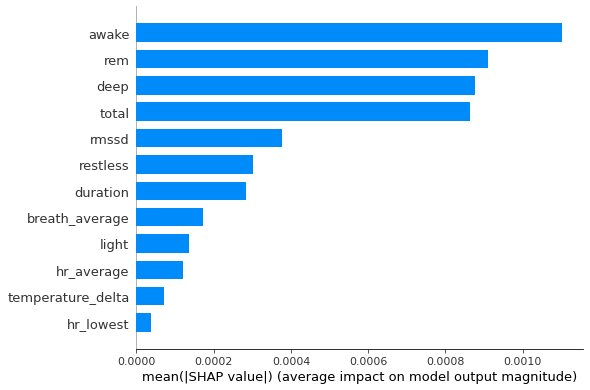

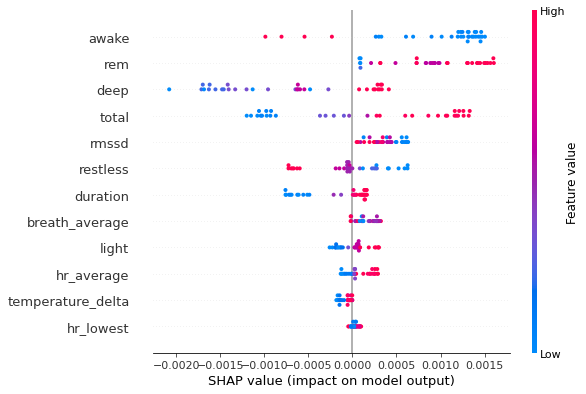



_______ time step 1 ___________


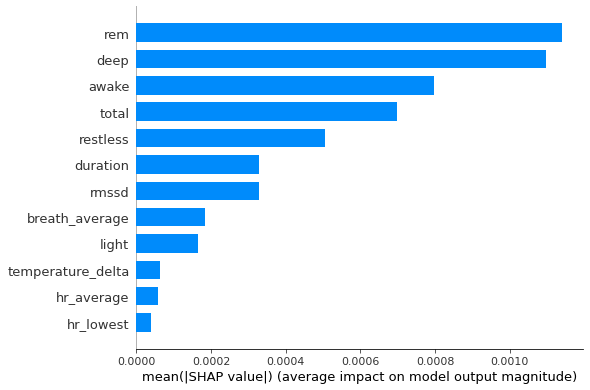

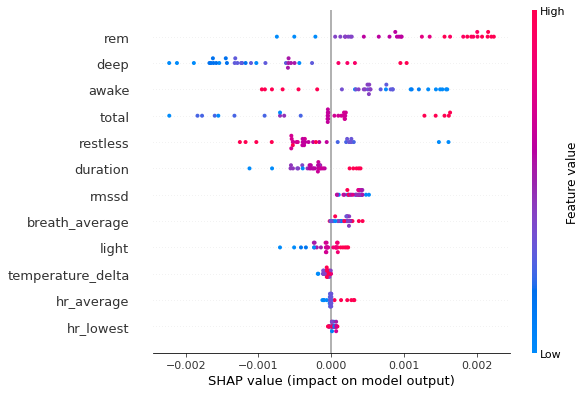



_______ time step 2 ___________


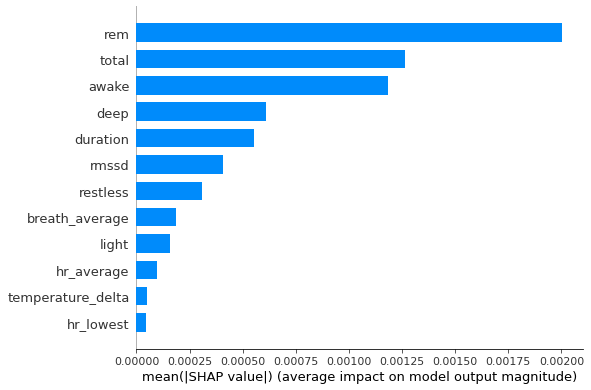

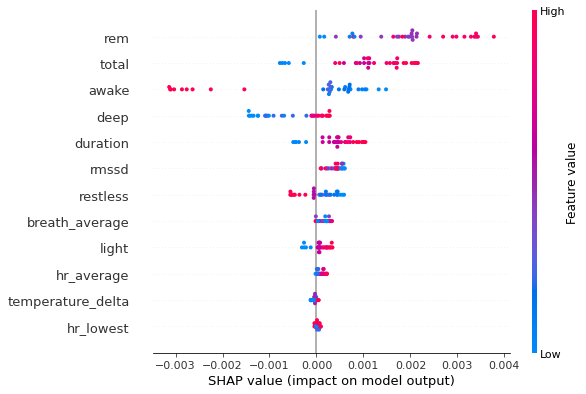

In [523]:
# SHAP for each time step
num_steps = 3
len_test_set = X_test_2D.shape[0]
# step = 0
for step in range(num_steps):
    indice = [i for i in list(range(len_test_set)) if i%num_steps == step]
    shap_values_2D_step = shap_values_2D[indice]
    x_test_2d_step = x_test_2d.iloc[indice]
    print("_______ time step {} ___________".format(step))
    shap.summary_plot(shap_values_2D_step, x_test_2d_step, plot_type="bar")
    shap.summary_plot(shap_values_2D_step, x_test_2d_step)
    print("\n")

Gradient Explainer

In [524]:
explainer_2 = shap.GradientExplainer(model, X[:1000])
shap_values_2 = explainer_2.shap_values(X_test[:window_len])


In [525]:
# avg of all observations
shap_average_abs_value_2 = np.abs(shap_values_2[0]).mean(axis=0)
shap.initjs()
x_average_value = pd.DataFrame(data=X_test[:window_len].mean(axis=0), columns = features)
shap.force_plot(0, shap_average_abs_value_2, x_average_value)

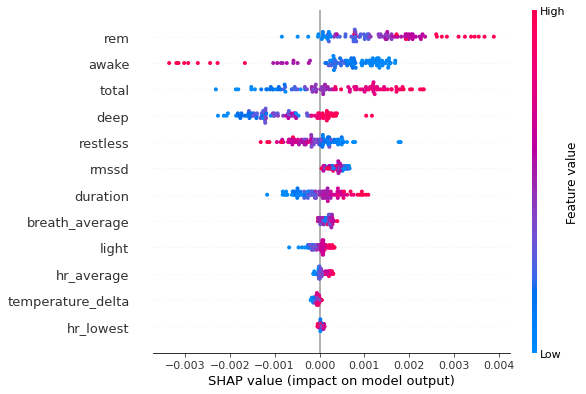

In [526]:
shap_values_train_2D = shap_values_2[0].reshape(-1,n_features)
X_train_2D = X_test[:window_len].reshape(-1,n_features)


shap.summary_plot(shap_values_train_2D, X_train_2D, features)

KL-CPD

In [15]:
df = pd.read_csv("test_df.csv",low_memory=False)
df.participant_id.unique()

array(['U-12HDU523T7TSN18MQNTU', 'U-1D2T72SSE7SWAZ6Y3WWR',
       'U-1DV1Y8WJ5MD3WEFER4M8', 'U-1GPMFTVN6JZLK4G5UKFA',
       'U-1SD8QUMRYKE2G68Q3TLQ', 'U-28FJ4MH5LMKRYD9RYMA8',
       'U-2BR9NZADKB65RW4BRRX1', 'U-4EJ5C427LV69H97ZBWY8',
       'U-5GFJ8ZSGYVAC4M46KQPU', 'U-5K9GSVTNZMKVGG9USNAU',
       'U-6BMA7MGD7W2R42Q522VF', 'U-7R8HJ63U96T1LVKMQ5FS',
       'U-7ZYS5MWSE339X5Q4PFPM', 'U-8APRNV5MXCTKHUKBQXXJ',
       'U-8ZKFQ6KLTMU17TT6DBF1', 'U-996KHR6BRCRUBVAJFN2A',
       'U-A9SASDZPDWVVNDQ798AL', 'U-BKQPVE7SQ6S4E3F2TCAT',
       'U-C2BA7MGYUNTWF3NXTUTA', 'U-D2UCPAJ8KSR2Z48YBDLV',
       'U-D5AXMU2ZVAVAJBDXGX18', 'U-DGSN59XXNJKXPS7T43QM',
       'U-DGVEHDE17B16BH6DM5CG', 'U-DTMUJEF9VXRWNYXFN4PU',
       'U-DVHWJ16M5F1CTKKKL26Y', 'U-FZFXQL6T5J3K7QHZJRTA',
       'U-GBVKWKY75LVWT9K8EK41', 'U-GQJYY3B2UWATFUBR49RW',
       'U-K6JWD1HWTBF9SR1KCH66', 'U-KKQZD8PEXGA7DH69Y1CK',
       'U-L3N39UPTS5L413SCXJ7K', 'U-L8KA5ZY6HBEEQJ2W7C6V',
       'U-LMZRH6ZQ8HXL7WQ4HKBB', 'U-M6ET7M4VDFLBW726UVRJ

In [16]:
id = 'U-C2BA7MGYUNTWF3NXTUTA'
one = df[df['participant_id']==id]
columns = ["deep", "hr_average", "rmssd", 'temperature_delta','breath_average','rem', 'daily_shifts']
one = one.fillna(method='ffill')
one = one.fillna(method='bfill')

one = one[columns]
from sklearn.preprocessing import MinMaxScaler
data = one.values
standardized_data = MinMaxScaler().fit_transform(data)
one = pd.DataFrame(standardized_data)
one.columns = columns

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cf319ecd0>,
      dtype=object)

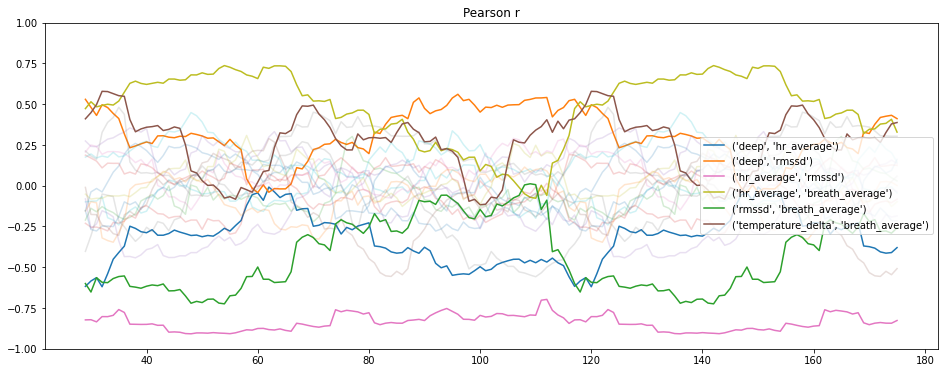

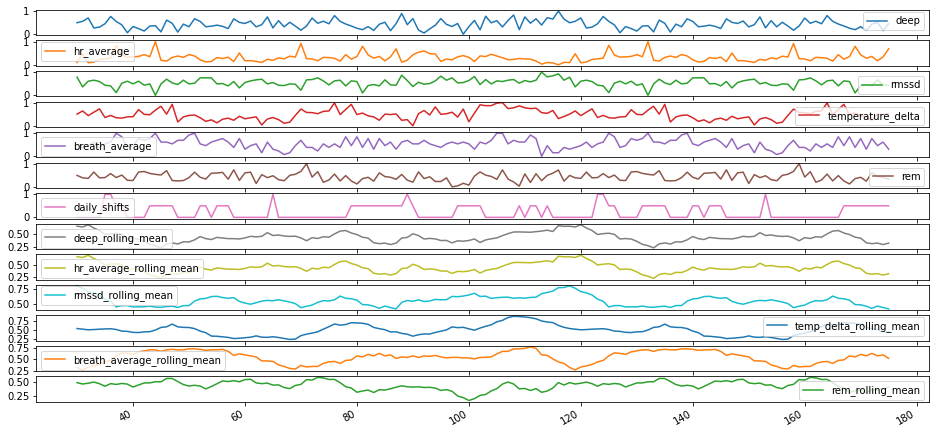

In [17]:
import scipy
# plot 
f, (ax1) = plt.subplots(1, 1 ,sharex='col')
f.set_figheight(6)
f.set_figwidth(16)

r_window_size = 30

combination = []
run_corr = np.empty([21, one.shape[0]-r_window_size])
i=0
for column_1 in one:
    for column_2 in one:
        if (column_1 != column_2) and (column_1+column_2 not in combination):
            run_corr[i] = one[column_1].rolling(window=r_window_size).corr(one[column_2])[r_window_size:]
            i+=1
            if (abs(scipy.stats.pearsonr(one[column_1], one[column_2])[0]) > 0.25):
                ax1.plot(one[column_1].rolling(window=r_window_size).corr(one[column_2]),
                         label = (column_1,column_2))
            else:
                ax1.plot(one[column_1].rolling(window=r_window_size).corr(one[column_2]),
                         alpha = 0.2)
        combination.append(column_1+column_2)
        combination.append(column_2+column_1)
            
ax1.set_ylim([-1, 1])
ax1.legend();
ax1.set_title('Pearson r')
ax1.legend(loc='right');
one[ 'deep_rolling_mean' ] = one.deep.rolling(7).mean()

one[ 'hr_average_rolling_mean' ] = one.deep.rolling(7).mean()
one[ 'rmssd_rolling_mean' ] = one.rmssd.rolling(7).mean()

one[ 'temp_delta_rolling_mean' ] = one.temperature_delta.rolling(7).mean()

one[ 'breath_average_rolling_mean' ] = one.breath_average.rolling(7).mean()

one[ 'rem_rolling_mean' ] = one.rem.rolling(7).mean()

one[r_window_size:].plot(subplots = True, legend =True, figsize=(16, 8))


In [18]:
# on correlations
ts = run_corr.T
# on dataset
tsd = one[r_window_size:].values

In [19]:
!pip install git+https://github.com/HolyBayes/klcpd
!pip install peakdetect
!pip install findpeaks

  Cloning https://github.com/HolyBayes/klcpd to /tmp/pip-req-build-p7gkf2q4
  Running command git clone -q https://github.com/HolyBayes/klcpd /tmp/pip-req-build-p7gkf2q4


In [20]:
from klcpd import KL_CPD
import findpeaks
dim, seq_length = ts.shape[1], ts.shape[0]
dimd, seq_lengthd = tsd.shape[1], tsd.shape[0]

model_kl = KL_CPD(dim)
#modeld = KL_CPD(dimd)
model_kl.fit(ts)
#modeld.fit(tsd)
preds = model_kl.predict(ts)
#predsd = modeld.predict(tsd)

  0%|          | 0/100 [00:00<?, ?it/s]volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


In [22]:
import matplotlib.pyplot as plt
import pandas as pd
ts_df = pd.DataFrame(data=ts)
#ts_dfd = pd.DataFrame(data=tsd)
#ts_dfd.columns = columns
preds_df =  pd.DataFrame(data=preds)
#preds_dfd =  pd.DataFrame(data=predsd)

In [23]:
from peakdetect import peakdetect
index = scipy.signal.find_peaks(preds_df[0].values)
index

(array([  2,  34,  43,  61,  74,  90,  92,  98, 122, 127, 130]), {})

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


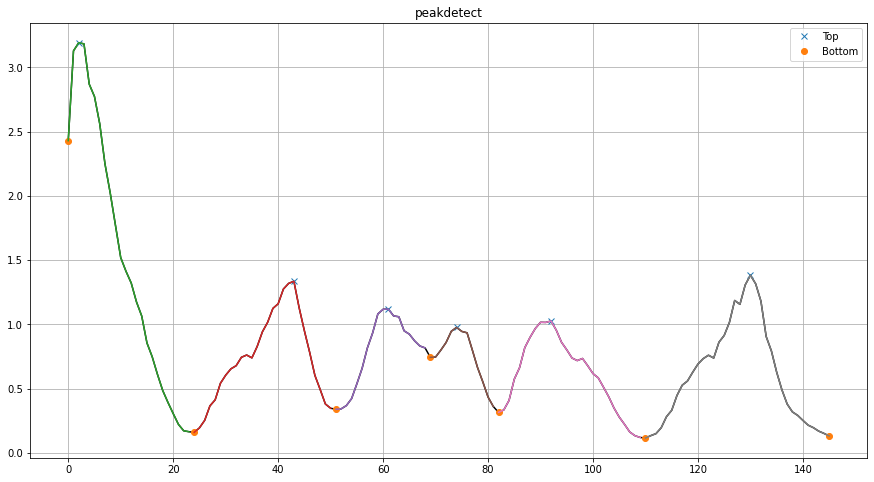

(None, <matplotlib.axes._subplots.AxesSubplot at 0x7f2ce7669a10>)

In [24]:
from findpeaks import findpeaks
x = preds_df[0]
# Initialize
fp = findpeaks(lookahead=4) # min number days in between 2 troughs
results = fp.fit(x)
# Plot
fp.plot()

In [25]:
results = results.get('df')
results = results.loc[results['valley'] == True]

In [26]:
a = results['x'].values
preds_df[0].values[a]

array([2.429021  , 0.16100529, 0.34023005, 0.7444032 , 0.31655556,
       0.11677127, 0.13286804], dtype=float32)

In [27]:
a

array([  0,  24,  51,  69,  82, 110, 145])

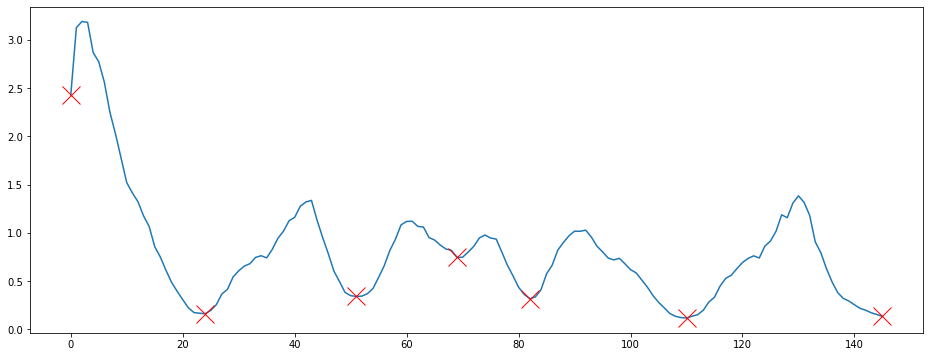

In [28]:
f, (ax1) = plt.subplots(1, 1 ,sharex='col')
f.set_figheight(6)
f.set_figwidth(16)

ax1.plot(preds_df)
ax1.plot(a
         ,preds_df[0].values[a], "x", color = 'red', markersize = 18)


In [6]:
# filter to one participant (later repeat analysis for all participants)
df = pd.read_csv("test_df.csv",low_memory=False)
one = df[df['participant_id']==id]
columns = ["awake","breath_average", "deep", "duration", "hr_average", "hr_lowest",
          "light", "rem", "restless", "temperature_delta","total", "rmssd", 'score']
features = ["awake","breath_average", "deep", "duration", "hr_average", "hr_lowest",
          "light", "rem", "restless", "temperature_delta","total",'rmssd']
#one = one.fillna(method='ffill')
#one = one.fillna(method='bfill')
one = one[columns]
#from sklearn.preprocessing import MinMaxScaler
#data = one.values
#standardized_data = MinMaxScaler().fit_transform(data)
#one = pd.DataFrame(standardized_data)
#one.columns = columns

In [30]:
preds_df[0].values[a]

array([2.429021  , 0.16100529, 0.34023005, 0.7444032 , 0.31655556,
       0.11677127, 0.13286804], dtype=float32)

In [31]:
!pip install shap
import shap
explainer = shap.DeepExplainer(model, X[:1000])

keras is no longer supported, please use tf.keras instead.


0


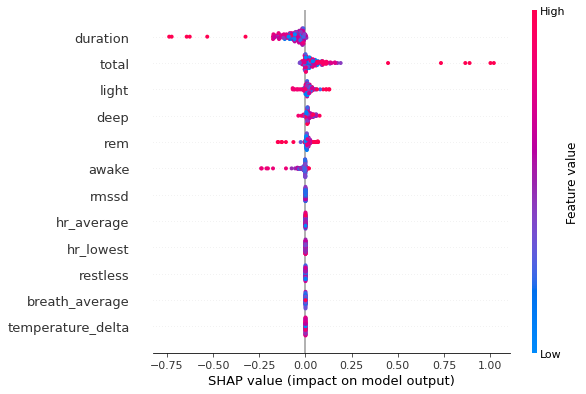

1


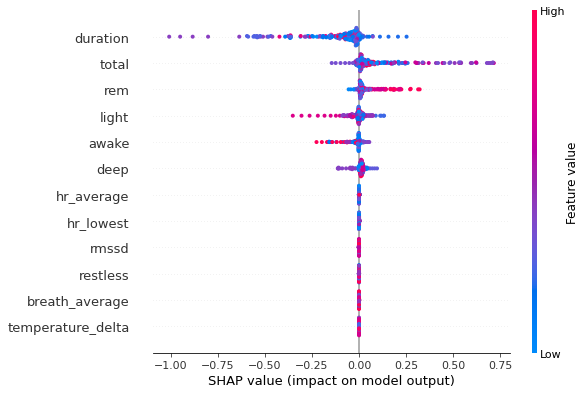

2


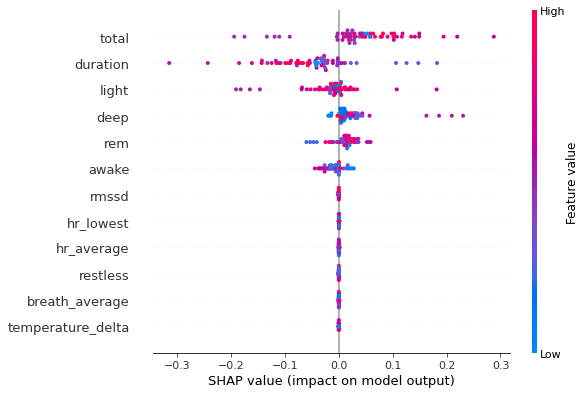

4


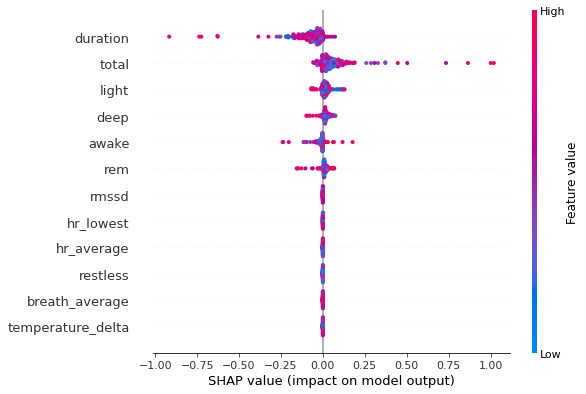

5


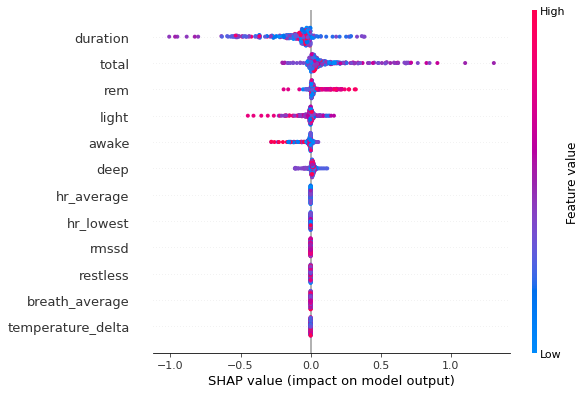

In [32]:
# function to split the dataset into windows
top_1 = []
top_2 = []
for i in range(len(preds_df[0].values[a])):
  if i <= len(preds_df[0].values[a])-2:
    sub = one[a[i]:a[i+1]]
    if sub.shape[0] >= n_steps:
      print(i)
      X_test,y_test = split_sequences(sub.values, n_steps)
      #import pdb; pdb.set_trace()
      shap_values = explainer.shap_values(X_test, check_additivity=False)
      # avg SHAP for all observations
      shap_average_value = np.abs(shap_values[0]).mean(axis=0)
      x_average_value = pd.DataFrame(data=X_test.mean(axis=0), columns = features)
      #shap.force_plot(0, shap_average_value, x_average_value)
      shap_values_2D = shap_values[0].reshape(-1,n_features)
      X_test_2D = X_test.reshape(-1,n_features)
      x_test_2d = pd.DataFrame(data=X_test_2D, columns = features)
      shap.initjs()

      #import pdb; pdb.set_trace()
      
      shap.summary_plot(shap_values_2D, x_test_2d)
      vals= np.abs(shap_values_2D).mean(0)
      feature_importance = pd.DataFrame(list(zip(features, vals)),columns=['col_name','feature_importance_vals'])
      feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
      top_1.append(feature_importance['col_name'].iloc[0])
      top_2.append(feature_importance['col_name'].iloc[1])

In [7]:
f = range(1,len(features)+1)
features_dct = dict(zip(features, features_dct))

In [8]:
prices

range(1, 13)

In [34]:
import seaborn as sns
color = ('r', 'g', 'b')

In [35]:
features_dct_inv = {v: k for k, v in features_dct.items()}
features_dct_inv

{1: 'awake',
 2: 'breath_average',
 3: 'deep',
 4: 'duration',
 5: 'hr_average',
 6: 'hr_lowest',
 7: 'light',
 8: 'rem',
 9: 'restless',
 10: 'temperature_delta',
 11: 'total',
 12: 'rmssd'}

In [36]:
top_1 = list(map(features_dct.get, top_1))
top_2 = list(map(features_dct.get, top_2))

In [37]:
b = []
for i in range(len(a)):
  if i <= len(preds_df[0].values[a])-2:
    if a[i+1]-a[i] >= n_steps:
      b.append(a[i])

In [38]:
import matplotlib.cm as cm
import matplotlib as matplotlib

def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=1):
    cmap_name = plt.colormaps()[82+value]
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  
    rgb = cmap(norm(abs(value)))[:3] 
    color = matplotlib.colors.rgb2hex(rgb)
    return color

0
1
2
3


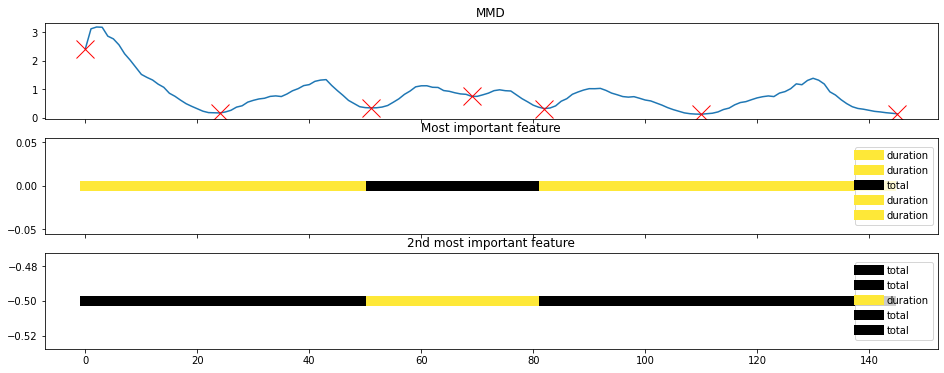

In [39]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1 ,sharex='col')
f.set_figheight(6)
f.set_figwidth(16)
for i in range(len(top_1)):
  if i == len(top_1)-1:
     ax2.plot(range(b[i], a[-1]), 
              [0]*len(range(b[i], a[-1])), 
              c =color_map_color(top_1[i]), linewidth = 10, label = features_dct_inv.get(top_1[i]))
     ax3.plot(range(b[i], a[-1]), 
              [-0.5]*len(range(b[i], a[-1])), 
              c =color_map_color(top_2[i]), linewidth = 10, label = features_dct_inv.get(top_2[i]))
  else:
    print(i)
    ax2.plot(range(b[i], b[i+1]), 
             [0]*len(range(b[i], b[i+1])), 
             c = color_map_color(top_1[i]), linewidth = 10, label = features_dct_inv.get(top_1[i]))
    ax3.plot(range(b[i], b[i+1]), 
             [-0.5]*len(range(b[i], b[i+1])), 
             c = color_map_color(top_2[i]), linewidth = 10, label = features_dct_inv.get(top_2[i]))
    
ax2.legend(loc='center right');
ax3.legend(loc='center right');

ax1.set_title('MMD')
ax2.set_title('Most important feature')
ax3.set_title('2nd most important feature')
ax1.plot(preds_df)
ax1.plot(a ,preds_df[0].values[a], "x", color = 'red', markersize = 18)